In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr


from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco


from netCDF4 import Dataset

import seawater

from analysis_package import plotting_functions
from analysis_package import open_datasets

from analysis_package import derive_potential_density_values_TEST
from analysis_package import integrate_on_density_surfaces
from analysis_package import ecco_masks

from importlib import reload

# reload modules during prototyping...
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)


"""
I made this script to check my potential density profile derived from ECCO data and calculated using the
seawater python package. My profile disagrees with the profile presented by Cessi 2019 but Malte and I think that that
one is wrong anyway..

"""
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
data_dir = "./nctiles_monthly/"

time_slice = np.arange(0,288)
        

In [3]:

PDENS_ds = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"PDENS",time_slice,rename_indices=False)
PDENS_ds_U = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"PDENS_U",time_slice,rename_indices=False)
PDENS_ds_V = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"PDENS_V",time_slice,rename_indices=False)

Loaded PDENS over time slice  

Loaded PDENS_U over time slice  

Loaded PDENS_V over time slice  



In [4]:
######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")


southern_ocean_mask_W, southern_ocean_mask_S, so_atl_basin_mask_W, so_atl_basin_mask_S, so_indpac_basin_mask_W, so_indpac_basin_mask_S = ecco_masks.get_basin_masks(maskW, maskS, maskC)


In [5]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################

grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)
cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)


In [6]:
PDENS_U_so_atl = PDENS_ds_U.isel(k=0)*so_atl_basin_mask_W
PDENS_V_so_atl = PDENS_ds_V.isel(k=0)*so_atl_basin_mask_S

In [7]:
lat_vals = np.arange(-90,90)


In [8]:
for lat in lat_vals:
    print(lat)
    lat_maskX, lat_maskY = ecco.vector_calc.get_latitude_masks(lat, cds['YC'], grid_xmitgcm)
    #print((PDENS_U_so_atl*lat_maskX + PDENS_V_so_atl*lat_maskY).min().values)

-90
-89
-88
-87
-86
-85
-84
-83
-82
-81
-80
-79
-78
-77
-76
-75
-74
-73
-72
-71
-70
-69
-68
-67
-66
-65
-64
-63
-62
-61
-60
-59
-58
-57
-56
-55
-54
-53
-52
-51
-50
-49
-48
-47
-46
-45
-44
-43
-42
-41
-40
-39
-38
-37
-36
-35
-34
-33
-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


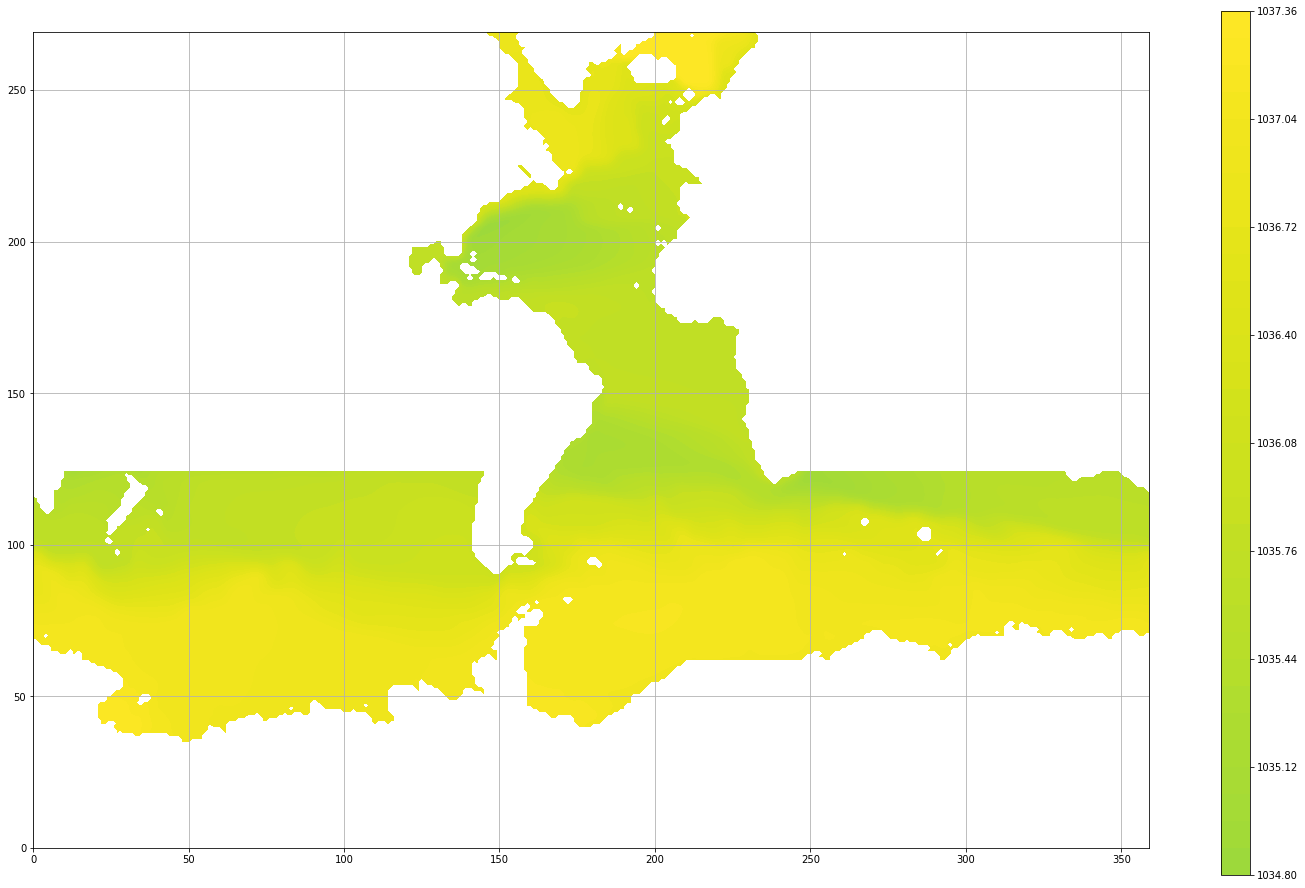

In [12]:
integrate_on_density_surfaces = reload(integrate_on_density_surfaces)
PDENS_ds_world = integrate_on_density_surfaces.stitch_tiles(PDENS_ds.PDENS.mean(dim="time")*so_atl_basin_mask_S.rename({"j_g":"j"}))

fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(nrows=1,ncols=1,hspace=0.02,wspace=0.05)
ax = fig.add_subplot(gs[0])

im = ax.contourf(PDENS_ds_world.isel(k=20),40,vmin=1020.)
ax.grid()
cb_ax = fig.add_axes([.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im,cax=cb_ax)

In [16]:
print(PDENS_ds_world)

<xarray.DataArray (x: 270, y: 360, k: 50)>
dask.array<shape=(270, 360, 50), dtype=float64, chunksize=(90, 90, 50)>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    tile     (y, x) int64 9 9 9 9 9 9 9 9 9 9 9 9 9 ... 5 5 5 5 5 5 5 5 5 5 5 5
    lon      (y, x) float64 68.39 75.18 81.8 88.08 ... 141.7 141.7 141.8 141.8
Dimensions without coordinates: x, y


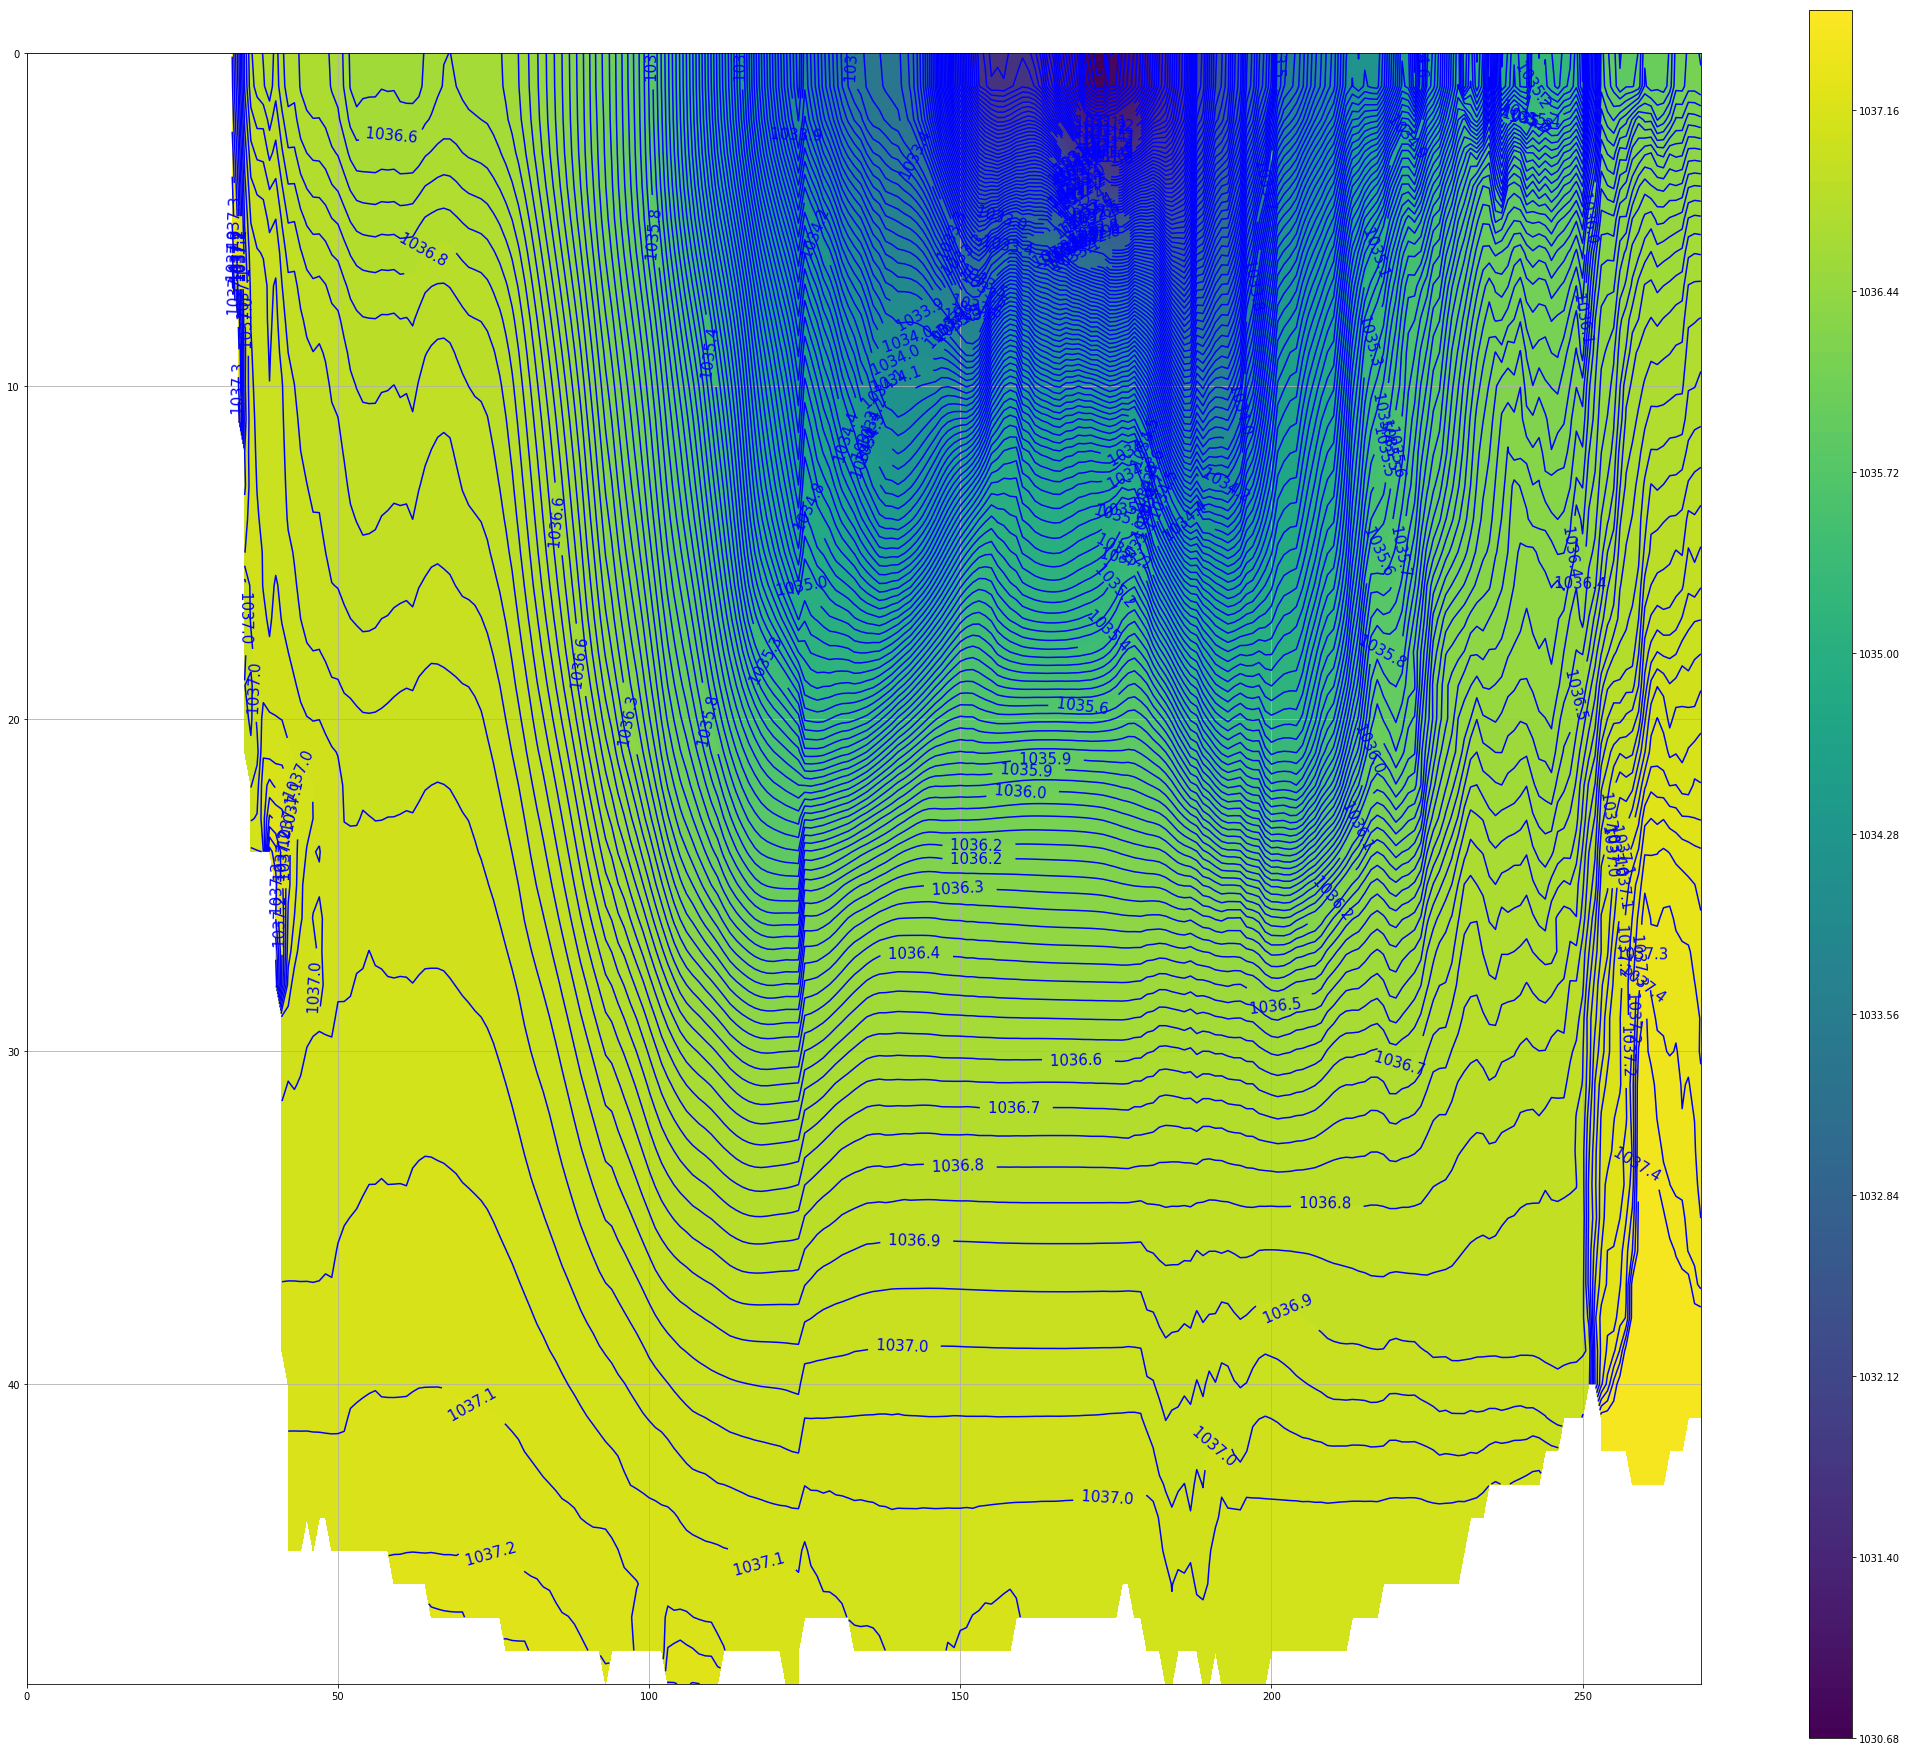

In [17]:
fig = plt.figure(figsize=(30,30))
gs = gridspec.GridSpec(nrows=1,ncols=1,hspace=0.02,wspace=0.05)
ax = fig.add_subplot(gs[0])

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s

vertical_levels = PDENS_ds.dep
#vertical_levels = np.arange(0,50)

PDENS_ds_world_time_mean = PDENS_ds_world#.mean(dim="time")
PDENS_ds_world_time_zonal_mean = PDENS_ds_world_time_mean.mean(dim="y")
im = ax.contourf(#a.isel(y=180).lat,
                 #vertical_levels,
                 PDENS_ds_world_time_zonal_mean.T,200)
im2 = ax.contour(#PDENS_ds_world.isel(y=180).lat,
                 #vertical_levels,
                 PDENS_ds_world_time_zonal_mean.T,200,colors=('b'))
ax.levels = [nf(val) for val in im.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%0.6r'
else:
    fmt = '%0.6r '
    

ax.clabel(im2, im2.levels, inline=True,fmt=fmt, fontsize=15)

ax.grid()
ax.invert_yaxis()
cb_ax = fig.add_axes([.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im,cax=cb_ax)

NameError: name 'P_INSITU_ds' is not defined

In [ ]:
print(PDENS_ds.dep)